# Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

from tqdm import tqdm

# Load Data

In [38]:
train_data = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/passive_train_data.csv')
test_data = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/passive_test_data.csv')
mlm_data = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_gap_results_df.csv')
df_target_detrended = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/df_target_detrended.csv')

In [41]:
# Rename t_current column first, then merge with train and test data
df_target_renamed = df_target_detrended.rename(columns={'t_current': 't_current_nn'})
train_data = train_data.merge(df_target_renamed[['PID', 'trial_date', 't_current_nn']], on=['PID', 'trial_date'], how='left')
test_data = test_data.merge(df_target_renamed[['PID', 'trial_date', 't_current_nn']], on=['PID', 'trial_date'], how='left')

In [290]:
# Check for empty, binary (0/1) columns and non-numeric columns
empty_cols = []
binary_cols = []
non_numeric_cols = []

for col in train_data.columns:
    # Check if column is empty (all NaN)
    if train_data[col].isna().all():
        empty_cols.append(col)
        continue
        
    # Check if column is non-numeric
    if not np.issubdtype(train_data[col].dtype, np.number):
        non_numeric_cols.append(col)
        continue
        
    # Check if column only contains 0s and 1s
    unique_vals = train_data[col].unique()
    unique_vals = unique_vals[~np.isnan(unique_vals)]  # Remove NaN values
    if set(unique_vals).issubset({0, 1}):
        binary_cols.append(col)

print("Empty columns:")
print(empty_cols)
print("\nBinary columns:")
print(binary_cols)
print("\nNon-numeric columns:")
print(non_numeric_cols)


Empty columns:
['passive_hk_activity_distanceCycling', 'passive_sk_visits_gym_distance', 'passive_sk_visits_home_distance', 'passive_sk_visits_gym_elapsed', 'passive_sk_device_total_usage_catalogs', 'passive_sk_device_total_usage_kids', 'passive_sk_device_total_usage_newsstand', 'passive_sk_device_total_usage_stickers', 'fe_lag_1_passive_hk_activity_distanceCycling', 'fe_lag_2_passive_hk_activity_distanceCycling', 'fe_lag_3_passive_hk_activity_distanceCycling', 'fe_lag_1_passive_sk_visits_gym_distance', 'fe_lag_2_passive_sk_visits_gym_distance', 'fe_lag_3_passive_sk_visits_gym_distance', 'fe_lag_1_passive_sk_visits_home_distance', 'fe_lag_2_passive_sk_visits_home_distance', 'fe_lag_3_passive_sk_visits_home_distance', 'fe_lag_1_passive_sk_visits_gym_elapsed', 'fe_lag_2_passive_sk_visits_gym_elapsed', 'fe_lag_3_passive_sk_visits_gym_elapsed', 'fe_lag_1_passive_sk_device_total_usage_catalogs', 'fe_lag_2_passive_sk_device_total_usage_catalogs', 'fe_lag_3_passive_sk_device_total_usage_catal

# Baseline Model

This function calculates the mean `t_current` for each subject in the training data, uses these means to make predictions on the test data, and evaluates the model's performance using Mean Absolute Error (MAE) and Root Mean Square Error (RMSE). It also generates visualizations of the prediction errors and actual vs predicted values.

In [43]:
def baseline_model(train_data, test_data, target_col='t_current'):
    """
    Implements a baseline model for predicting target values.

    This function calculates the mean target value for each subject in the training data,
    uses these means to make predictions on the test data, and evaluates the model's
    performance using Mean Absolute Error (MAE) and Root Mean Square Error (RMSE).
    It also generates visualizations of the prediction errors and actual vs predicted values.

    Parameters:
    train_data (pd.DataFrame): Training data containing 'PID' and target column.
    test_data (pd.DataFrame): Test data containing 'PID' and target column.
    target_col (str): Name of the target column to predict. Defaults to 't_current'.

    Returns:
    tuple: A tuple containing:
        - mae (float): Mean Absolute Error of the predictions.
        - rmse (float): Root Mean Square Error of the predictions.
        - test_data_clean (pd.DataFrame): Test data with predictions and error calculations.

    The function also prints the MAE and RMSE, and displays two plots:
    1. A histogram of prediction errors.
    2. A scatter plot of actual vs predicted target values.
    """

    # Calculate within-subject mean for target in train data
    subject_means = train_data.groupby('PID')[target_col].mean()

    # Make predictions
    test_data['predicted_target'] = test_data['PID'].map(subject_means)

    # Remove rows with NaN values
    test_data_clean = test_data.dropna(subset=[target_col, 'predicted_target'])

    # Calculate differences
    test_data_clean = test_data_clean.copy()
    test_data_clean.loc[:, 'prediction_error'] = test_data_clean[target_col] - test_data_clean['predicted_target']

    # Calculate MAE and RMSE
    mae = mean_absolute_error(test_data_clean[target_col], test_data_clean['predicted_target'])
    rmse = np.sqrt(mean_squared_error(test_data_clean[target_col], test_data_clean['predicted_target']))

    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Square Error: {rmse:.4f}")

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot A: Distribution of Prediction Errors
    sns.histplot(test_data_clean['prediction_error'], kde=True, ax=ax1)
    ax1.set_xlabel('Prediction Error', fontsize=22)
    ax1.set_ylabel('Count', fontsize=22)
    ax1.axvline(x=0, color='r', linestyle='--')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=32, fontweight='bold', va='top', ha='right')

    # Plot B: Actual vs Predicted Values
    ax2.scatter(test_data_clean[target_col], test_data_clean['predicted_target'], alpha=0.5)
    ax2.plot([test_data_clean[target_col].min(), test_data_clean[target_col].max()], 
             [test_data_clean[target_col].min(), test_data_clean[target_col].max()], 
             'r--', lw=2)
    ax2.set_xlabel('Actual IB Gap', fontsize=22)
    ax2.set_ylabel('Predicted IB Gap', fontsize=22)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=32, fontweight='bold', va='top', ha='right')

    plt.tight_layout()
    plt.show()

Mean Absolute Error: 0.7617
Root Mean Square Error: 0.9594


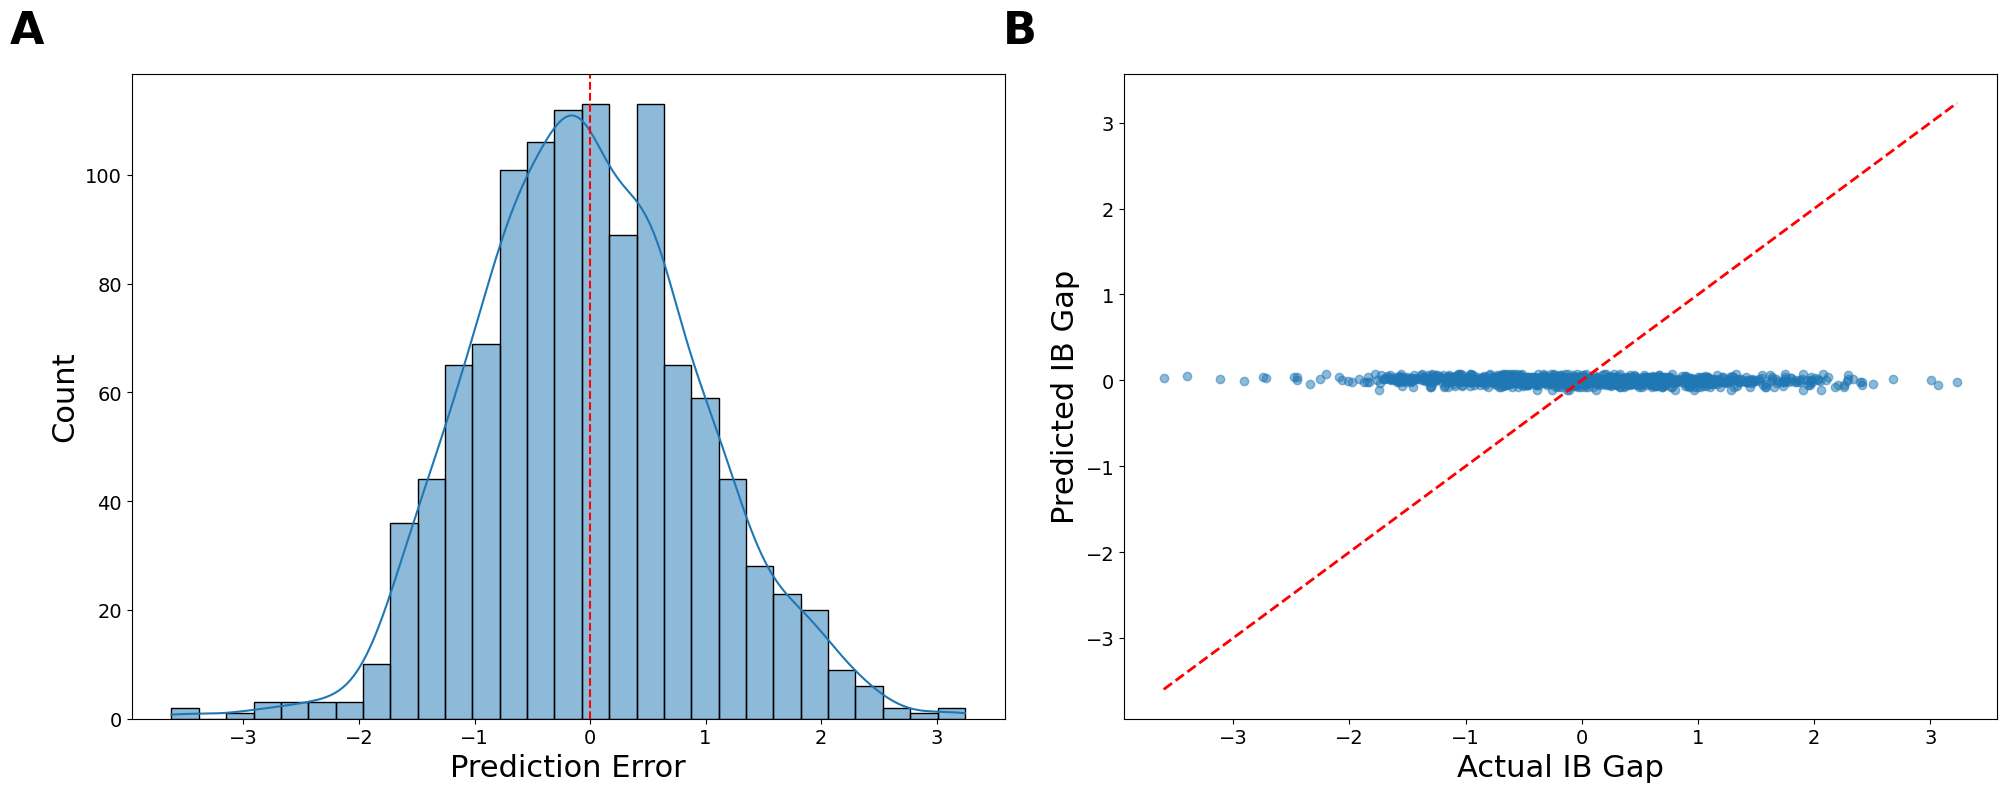

In [292]:
baseline_model(train_data, test_data, target_col='t_current')

Mean Absolute Error: 11.5068
Root Mean Square Error: 15.1274


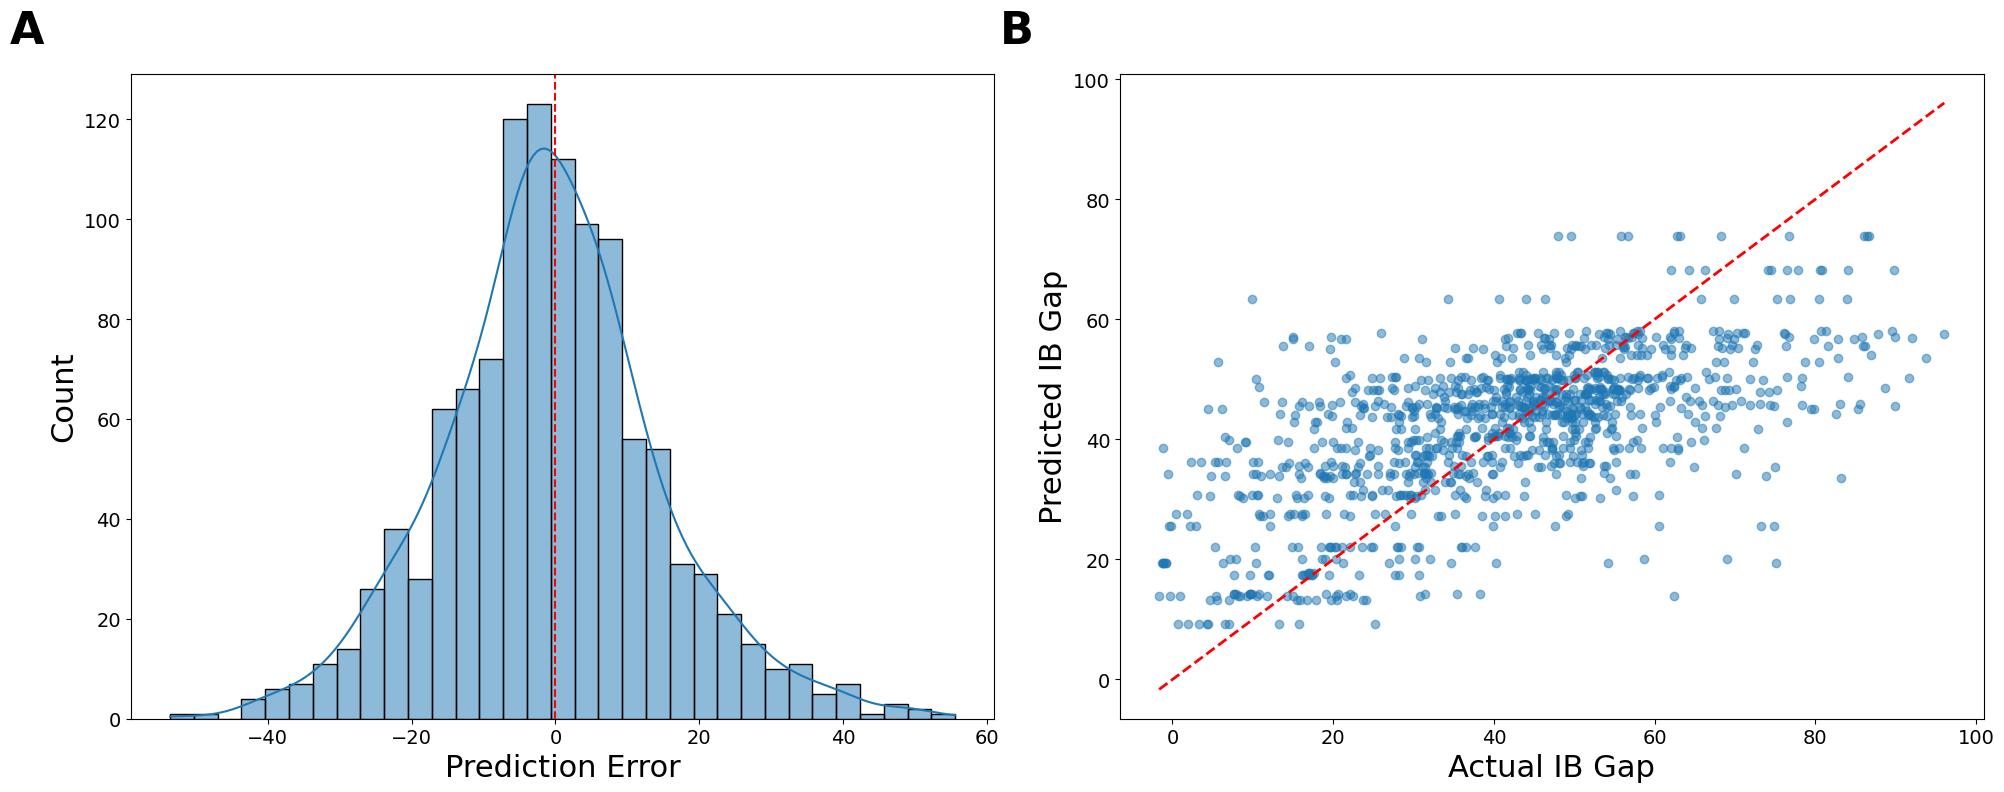

In [291]:
baseline_model(train_data, test_data, target_col='t_current_nn')

# Hierarchical Model

## MLM of Training Data Predictors

Rightly or wrongly I fit the MLMs to see which variables were predictive of the target to 

In [89]:
# Function to fit single predictor MLM

def single_predictor_mlm_iterator(df, model_columns, target_col='t_current', random_intercepts=False):
    """
    Fits mixed linear models for each predictor variable to predict target variable.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the normalized feature data and target variable
    model_columns : list
        List of feature names to fit models for
    target_col : str
        Name of target column to predict (default: 't_current')
    random_intercepts : bool
        Whether to include random intercepts in the model (default: False)
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing model results for each feature, sorted by absolute t-value.
        Includes coefficients, t-values, p-values, and group statistics.
    """
    # Initialize an empty list to store results
    results = []

    # Loop through all variables with progress bar
    for col in tqdm(model_columns, desc="Fitting models"):
        try:
            # Prepare the data
            model_data = df[[col, target_col, 'PID']].dropna()
            
            # Filter out participants with less than 10 data points
            group_sizes = model_data.groupby('PID').size()
            valid_pids = group_sizes[group_sizes >= 10].index
            model_data = model_data[model_data['PID'].isin(valid_pids)]
            
            # Filter out columns with less than 10 subjects
            no_subs = len(np.unique(model_data['PID']))
            
            # Only proceed if there's enough data
            if len(model_data) > 0 and no_subs >= 10:
                if random_intercepts:
                    md = smf.mixedlm(f"{target_col} ~ 1 + {col}",
                        model_data,
                        groups=model_data["PID"],
                        re_formula=f"1 + {col}")
                else:
                    md = smf.mixedlm(f"{target_col} ~ 0 + {col}",
                        model_data,
                        groups=model_data["PID"],
                        re_formula=f"0 + {col}")

                converged = True
                try:
                    fit = md.fit(method='nm',
                                maxiter=1000,
                                start_params=None,
                                full_output=True)
                except:
                    print("Model failed to converge with nm")
                    try:
                        # Try alternate optimizer
                        fit = md.fit(method='bfgs',
                                    maxiter=1000,
                                    full_output=True)
                    except:
                        print(f"Model failed to converge with both optimizers for {col}")
                        converged = False
                
                # Extract relevant information
                coef = fit.params[col]
                coef_sd = fit.bse[col]
                t_value = fit.tvalues[col]
                p_value = fit.pvalues[col]
                
                # Get group information
                groups = model_data.groupby('PID')
                n_groups = len(groups)
                min_group_size = groups.size().min()
                max_group_size = groups.size().max()
                mean_group_size = groups.size().mean()
                median_group_size = groups.size().median()
                
                # Append results to the list
                results.append({
                    'feature': col,
                    'coefficient': coef,
                    'coefficient_sd': coef_sd,
                    't_value': t_value,
                    'abs_t_value': abs(t_value),
                    'p_value': p_value,
                    'n_groups': n_groups,
                    'min_group_size': min_group_size,
                    'max_group_size': max_group_size,
                    'mean_group_size': mean_group_size,
                    'median_group_size': median_group_size,
                    'converged': converged
                })
        except Exception as e:
            print(f"Error fitting model for {col}: {str(e)}")

    # Create a dataframe from the results
    mlm_gap_results_df = pd.DataFrame(results)

    # Sort the dataframe by absolute t-value in descending order
    mlm_gap_results_df = mlm_gap_results_df.sort_values('abs_t_value', ascending=False).reset_index(drop=True)
    
    return mlm_gap_results_df

In [102]:
# Get all features that were significant in the MLM above z = 3
model_columns = mlm_data[mlm_data['abs_t_value'] > 3]['feature'].tolist()

# Fit the model
mlm_gap_results_df = single_predictor_mlm_iterator(train_data, model_columns, target_col='t_current', random_intercepts=False)

Fitting models:   0%|          | 0/221 [00:00<?, ?it/s]/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
Fitting models:   0%|          | 1/221 [00:00<00:31,  7.10it/s]/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(

In [104]:
mlm_gap_results_df.head(10)

,feature,coefficient,coefficient_sd,t_value,abs_t_value,p_value,n_groups,min_group_size,max_group_size,mean_group_size,median_group_size,converged
0,passive_sk_device_total_unlocks,-0.220936,0.020438,-10.810124,10.810124,3.082536e-27,105,12,61,43.571429,41.0,True
1,passive_hk_activity_activeEnergyBurned,-0.243828,0.027364,-8.910383,8.910383,5.085659e-19,98,10,61,42.500000,42.0,True
2,passive_sk_device_total_usage_productivity,-0.202175,0.025582,-7.902884,7.902884,2.725229e-15,105,12,61,43.323810,41.0,True
3,fe_lag_2_passive_sk_keyboard_sentiment_combine...,-0.237647,0.032152,-7.391412,7.391412,1.452774e-13,101,13,59,41.534653,39.0,True
4,fe_lag_1_passive_sk_messages_incoming,-0.175171,0.024455,-7.163079,7.163079,7.888477e-13,102,20,60,40.970588,40.0,True
5,fe_rollingMean_3_passive_hk_activity_steps,-0.173638,0.024560,-7.069969,7.069969,1.549682e-12,104,13,61,46.278846,42.0,True
6,fe_rollingMean_3_passive_sk_keyboard_sentiment...,-0.279245,0.041006,-6.809901,6.809901,9.766613e-12,103,13,61,44.349515,42.0,True
7,passive_sk_device_total_usage_business,-0.278175,0.041546,-6.695644,6.695644,2.147238e-11,100,12,61,43.270000,41.0,True
8,fe_rollingMean_5_passive_sk_visits_home_elapsed,-0.270447,0.040421,-6.690715,6.690715,2.220823e-11,87,13,61,42.172414,41.0,True
9,fe_rollingMean_3_passive_sk_visits_work_elapsed,-0.320706,0.049499,-6.478991,6.478991,9.233827e-11,63,13,61,41.079365,40.0,True


In [92]:
mlm_gap_results_df_nn.head()

,feature,coefficient,coefficient_sd,t_value,abs_t_value,p_value,n_groups,min_group_size,max_group_size,mean_group_size,median_group_size,converged
0,fe_rollingSD_7_passive_sk_device_total_unlocks,40.241228,1.176544,34.202913,34.202913,2.188499e-256,105,13,60,43.733333,41.0,True
1,passive_sk_telephony_speakingRate_variance,-4.362348,0.139319,-31.311991,31.311991,3.204614e-215,76,10,56,26.171053,28.0,True
2,fe_rollingSD_7_passive_sk_calls_outgoing,36.138147,1.165059,31.018286,31.018286,3.055765e-211,103,13,60,43.524272,41.0,True
3,fe_rollingSD_7_passive_sk_keyboard_total_typin...,37.783069,1.234695,30.601131,30.601131,1.182263e-205,98,13,60,41.183673,40.0,True
4,fe_rollingSD_7_passive_sk_keyboard_sentiment_c...,36.069557,1.185848,30.416687,30.416687,3.305147e-203,103,13,60,43.718447,41.0,True


In [305]:
def fit_single_variable_mlm(data, predictor, target='t_current', random_intercepts=False):
    """
    Fit a single variable mixed linear model with random intercepts and/or slopes.
    
    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing the predictor, target and PID columns
    predictor : str
        Name of predictor column to use in model
    target : str, default='t_current'
        Name of target column to predict
    random_intercepts : bool, default=False
        Whether to include random intercepts in model
        
    Returns
    -------
    tuple
        Tuple containing (model fit object, AIC, BIC)
    """
    model_data = data[[predictor, target, 'PID']].dropna()
            
    # Filter out participants with less than 10 data points
    group_sizes = model_data.groupby('PID').size()
    valid_pids = group_sizes[group_sizes >= 10].index
    model_data = model_data[model_data['PID'].isin(valid_pids)]

    # Filter out columns with less than 10 subjects
    no_subs = len(np.unique(model_data['PID']))

    # Only proceed if there's enough data
    if len(model_data) > 0 and no_subs >= 10:
        if random_intercepts:
            md = smf.mixedlm(f"{target} ~ 1 + {predictor}",
                model_data,
                groups=model_data["PID"],
                re_formula=f"1 + {predictor}")
        else:
            md = smf.mixedlm(f"{target} ~ 1 + {predictor}",
                model_data,
                groups=model_data["PID"],
                re_formula=f"0 + {predictor}")

        converged = True
        try:
            fit = md.fit(method='nm',
                        maxiter=1000,
                        start_params=None,
                        full_output=True)
                        
            # Calculate AIC and BIC by hand
            n = len(model_data)  # number of observations
            k = len(fit.params)  # number of parameters
            ll = fit.llf  # log likelihood
            
            # AIC = -2ln(L) + 2k
            aic = -2 * ll + 2 * k
            
            # BIC = -2ln(L) + k*ln(n) 
            bic = -2 * ll + k * np.log(n)
            
        except:
            print("Model failed to converge with bfgs")
            try:
                # Try alternate optimizer
                fit = md.fit(method='bfgs',
                            maxiter=1000,
                            full_output=True)
                            
                # Calculate AIC and BIC by hand
                n = len(model_data)
                k = len(fit.params)
                ll = fit.llf
                
                aic = -2 * ll + 2 * k
                bic = -2 * ll + k * np.log(n)
                
            except:
                print(f"Model failed to converge with both optimizers for {predictor}")
                converged = False
                return None, None, None

        # Get fixed effects
        fixed_intercept = fit.fe_params[0]
        fixed_slope = fit.fe_params[1]

        # Get random effects
        random_effects = fit.random_effects

        # Create plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Get slopes for color mapping - Modified to handle both cases
        slopes = []
        for pid in random_effects.keys():
            re = random_effects[pid]
            if random_intercepts:
                # With random intercepts, slope is at index 1
                subj_slope = fixed_slope + re[1]
            else:
                # Without random intercepts, only slope exists at index 0
                subj_slope = fixed_slope + re[0]
            slopes.append(subj_slope)

        # Create colormap based on slopes
        norm = plt.Normalize(min(slopes), max(slopes))
        cmap = plt.cm.viridis

        # Plot individual lines for each subject using their own x range
        for pid, slope in zip(random_effects.keys(), slopes):
            subject_data = model_data[model_data['PID'] == pid]
            x_min = subject_data[predictor].min()
            x_max = subject_data[predictor].max()
            x_range = np.linspace(x_min, x_max, 100)
            
            re = random_effects[pid]
            if random_intercepts:
                subj_intercept = fixed_intercept + re[0]
                subj_slope = fixed_slope + re[1]
            else:
                subj_intercept = fixed_intercept  # Use fixed intercept only
                subj_slope = fixed_slope + re[0]
            y = subj_intercept + subj_slope * x_range
            ax.plot(x_range, y, color=cmap(norm(slope)), alpha=0.5)

        # Plot fixed effects line across full range
        x_range_full = np.linspace(model_data[predictor].min(), model_data[predictor].max(), 100)
        y_fixed = fixed_intercept + fixed_slope * x_range_full
        ax.plot(x_range_full, y_fixed, 'k-', linewidth=3, label='Fixed Effects')

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        plt.colorbar(sm, ax=ax, label='Slope')

        ax.set_xlabel(predictor)
        ax.set_ylabel(target)
        title = 'Mixed Effects Model: Random Slopes' if not random_intercepts else 'Mixed Effects Model: Random Intercepts and Slopes'
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        plt.show()
        
        print(f"--------------------------------")
        print(f"AIC: {aic:.4f}")
        print(f"BIC: {bic:.4f}")
        print(f"--------------------------------")
        print(fit.summary())
        # Calculate mean survey completion rates for positive vs negative slope groups
        slopes_df = pd.DataFrame({
            'PID': list(random_effects.keys()),
            'slope': slopes
        })
        
        # Merge with the original data to get survey_complete counts
        slopes_df = slopes_df.merge(
            train_data.groupby('PID')['survey_complete'].sum().reset_index(),
            on='PID'
        )
        
        # Split into positive and negative slope groups
        pos_slope_surveys = slopes_df[slopes_df['slope'] > 0]['survey_complete']
        neg_slope_surveys = slopes_df[slopes_df['slope'] <= 0]['survey_complete']
        
        # Calculate means and confidence intervals
        from scipy import stats
        
        pos_mean = pos_slope_surveys.mean()
        pos_ci = stats.t.interval(
            confidence=0.95,
            df=len(pos_slope_surveys)-1,
            loc=pos_mean,
            scale=stats.sem(pos_slope_surveys)
        )
        
        neg_mean = neg_slope_surveys.mean()
        neg_ci = stats.t.interval(
            confidence=0.95,
            df=len(neg_slope_surveys)-1,
            loc=neg_mean,
            scale=stats.sem(neg_slope_surveys)
        )
        
        print("\nMean Survey Completion Rates:")
        print(f"Positive slopes (n={len(pos_slope_surveys)}): {pos_mean:.2f} surveys [95% CI: {pos_ci[0]:.2f}, {pos_ci[1]:.2f}]")
        print(f"Negative slopes (n={len(neg_slope_surveys)}): {neg_mean:.2f} surveys [95% CI: {neg_ci[0]:.2f}, {neg_ci[1]:.2f}]")
        
    # return None, None, None

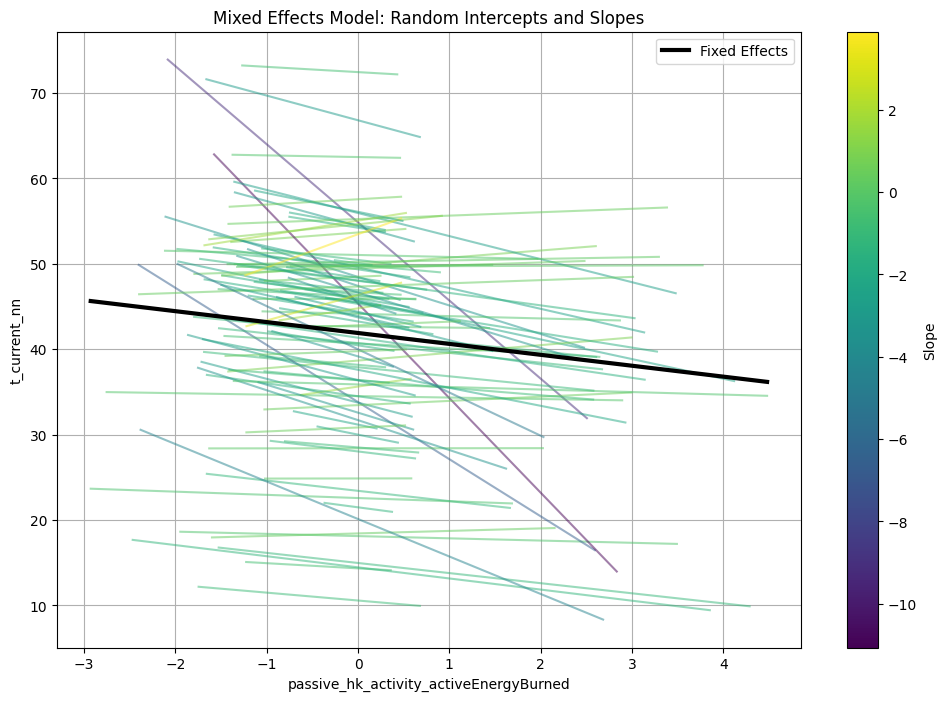

--------------------------------
AIC: 35318.0003
BIC: 35349.6727
--------------------------------
                            Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             t_current_nn
No. Observations:             4165                Method:                         REML        
No. Groups:                   98                  Scale:                          257.7586    
Min. group size:              10                  Log-Likelihood:                 -17654.0002 
Max. group size:              61                  Converged:                      Yes         
Mean group size:              42.5                                                            
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------

In [306]:
fit_single_variable_mlm(train_data, 'passive_hk_activity_activeEnergyBurned', target='t_current_nn', random_intercepts=True)

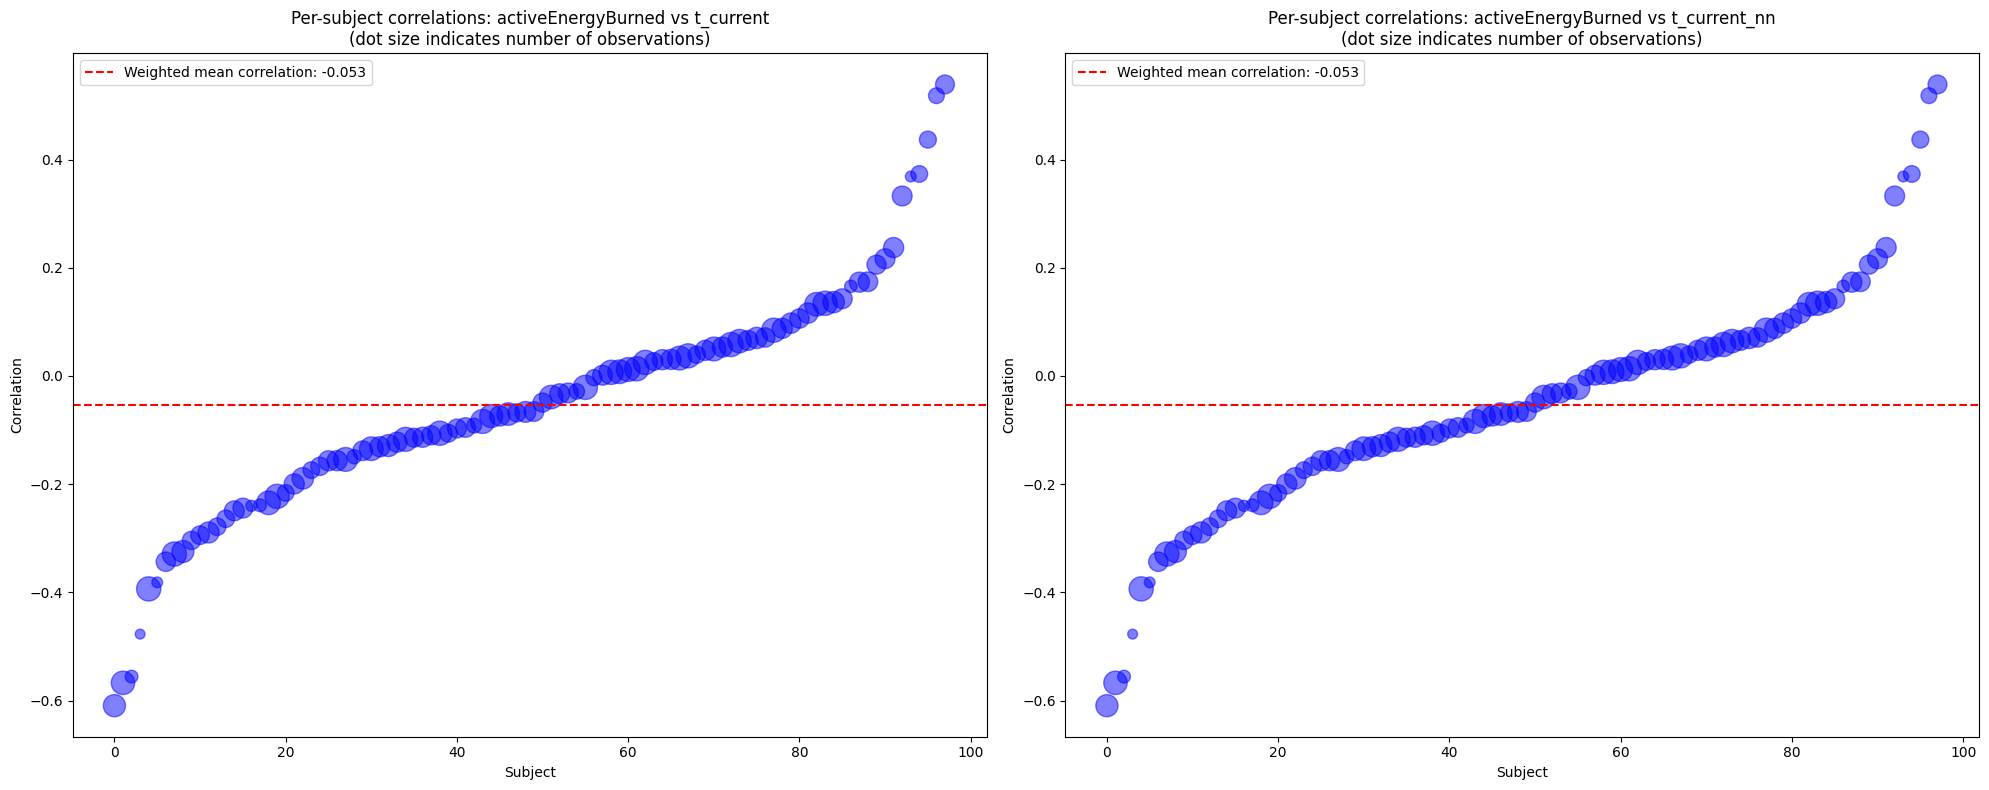

In [264]:
# Calculate per-subject correlations and observation counts
correlations_t = []
correlations_t_nn = []
n_obs_t = []
n_obs_t_nn = []
pids = train_data['PID'].unique()
pid_correlations = []

for pid in pids:
    subject_data = train_data[train_data['PID'] == pid]
    
    # Calculate correlation and obs count for t_current, only if there are valid values
    if not subject_data['passive_hk_activity_activeEnergyBurned'].isna().all() and not subject_data['t_current'].isna().all():
        valid_data = subject_data[['passive_hk_activity_activeEnergyBurned', 't_current']].dropna()
        # Only include if at least 10 observations
        if len(valid_data) >= 10:
            corr_t = valid_data['passive_hk_activity_activeEnergyBurned'].corr(valid_data['t_current'])
            if not np.isnan(corr_t):
                correlations_t.append(corr_t)
                n_obs_t.append(len(valid_data))
                pid_correlations.append({
                    'PID': pid,
                    'correlation': corr_t,
                    'n_obs': len(valid_data),
                    'target': 't_current'
                })
    
    # Calculate correlation and obs count for t_current_nn, only if there are valid values
    if not subject_data['passive_hk_activity_activeEnergyBurned'].isna().all() and not subject_data['t_current_nn'].isna().all():
        valid_data = subject_data[['passive_hk_activity_activeEnergyBurned', 't_current_nn']].dropna()
        # Only include if at least 10 observations
        if len(valid_data) >= 10:
            corr_t_nn = valid_data['passive_hk_activity_activeEnergyBurned'].corr(valid_data['t_current_nn'])
            if not np.isnan(corr_t_nn):
                correlations_t_nn.append(corr_t_nn)
                n_obs_t_nn.append(len(valid_data))
                pid_correlations.append({
                    'PID': pid,
                    'correlation': corr_t_nn,
                    'n_obs': len(valid_data),
                    'target': 't_current_nn'
                })

# Convert to dataframe
pid_correlations_df = pd.DataFrame(pid_correlations)

# Get PIDs with 5 most negative and positive correlations for each target, with at least 25 observations
most_negative_t = pid_correlations_df[(pid_correlations_df['target'] == 't_current') & 
                                    (pid_correlations_df['n_obs'] >= 25)].nsmallest(5, 'correlation')['PID'].tolist()
most_positive_t = pid_correlations_df[(pid_correlations_df['target'] == 't_current') & 
                                    (pid_correlations_df['n_obs'] >= 25)].nlargest(5, 'correlation')['PID'].tolist()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

# Sort correlations and corresponding observation counts
sorted_indices_t = np.argsort(correlations_t)
correlations_t_sorted = np.array(correlations_t)[sorted_indices_t]
n_obs_t_sorted = np.array(n_obs_t)[sorted_indices_t]

# Calculate weighted mean for t_current
mean_corr_t = np.average(correlations_t, weights=n_obs_t)

# Plot correlations for t_current with size based on observations
ax1.scatter(range(len(correlations_t)), correlations_t_sorted, alpha=0.5, 
           s=[n*5 for n in n_obs_t_sorted], c='blue')
ax1.axhline(y=mean_corr_t, color='r', linestyle='--', 
            label=f'Weighted mean correlation: {mean_corr_t:.3f}')
ax1.set_xlabel('Subject')
ax1.set_ylabel('Correlation')
ax1.set_title('Per-subject correlations: activeEnergyBurned vs t_current\n(dot size indicates number of observations)')
ax1.legend()

# Sort correlations and corresponding observation counts for t_current_nn
sorted_indices_t_nn = np.argsort(correlations_t_nn)
correlations_t_nn_sorted = np.array(correlations_t_nn)[sorted_indices_t_nn]
n_obs_t_nn_sorted = np.array(n_obs_t_nn)[sorted_indices_t_nn]

# Calculate weighted mean for t_current_nn
mean_corr_t_nn = np.average(correlations_t_nn, weights=n_obs_t_nn)

# Plot correlations for t_current_nn with size based on observations
ax2.scatter(range(len(correlations_t_nn)), correlations_t_nn_sorted, alpha=0.5,
           s=[n*5 for n in n_obs_t_nn_sorted], c='blue')
ax2.axhline(y=mean_corr_t_nn, color='r', linestyle='--',
            label=f'Weighted mean correlation: {mean_corr_t_nn:.3f}')
ax2.set_xlabel('Subject')
ax2.set_ylabel('Correlation')
ax2.set_title('Per-subject correlations: activeEnergyBurned vs t_current_nn\n(dot size indicates number of observations)')
ax2.legend()

plt.tight_layout()
plt.show()


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


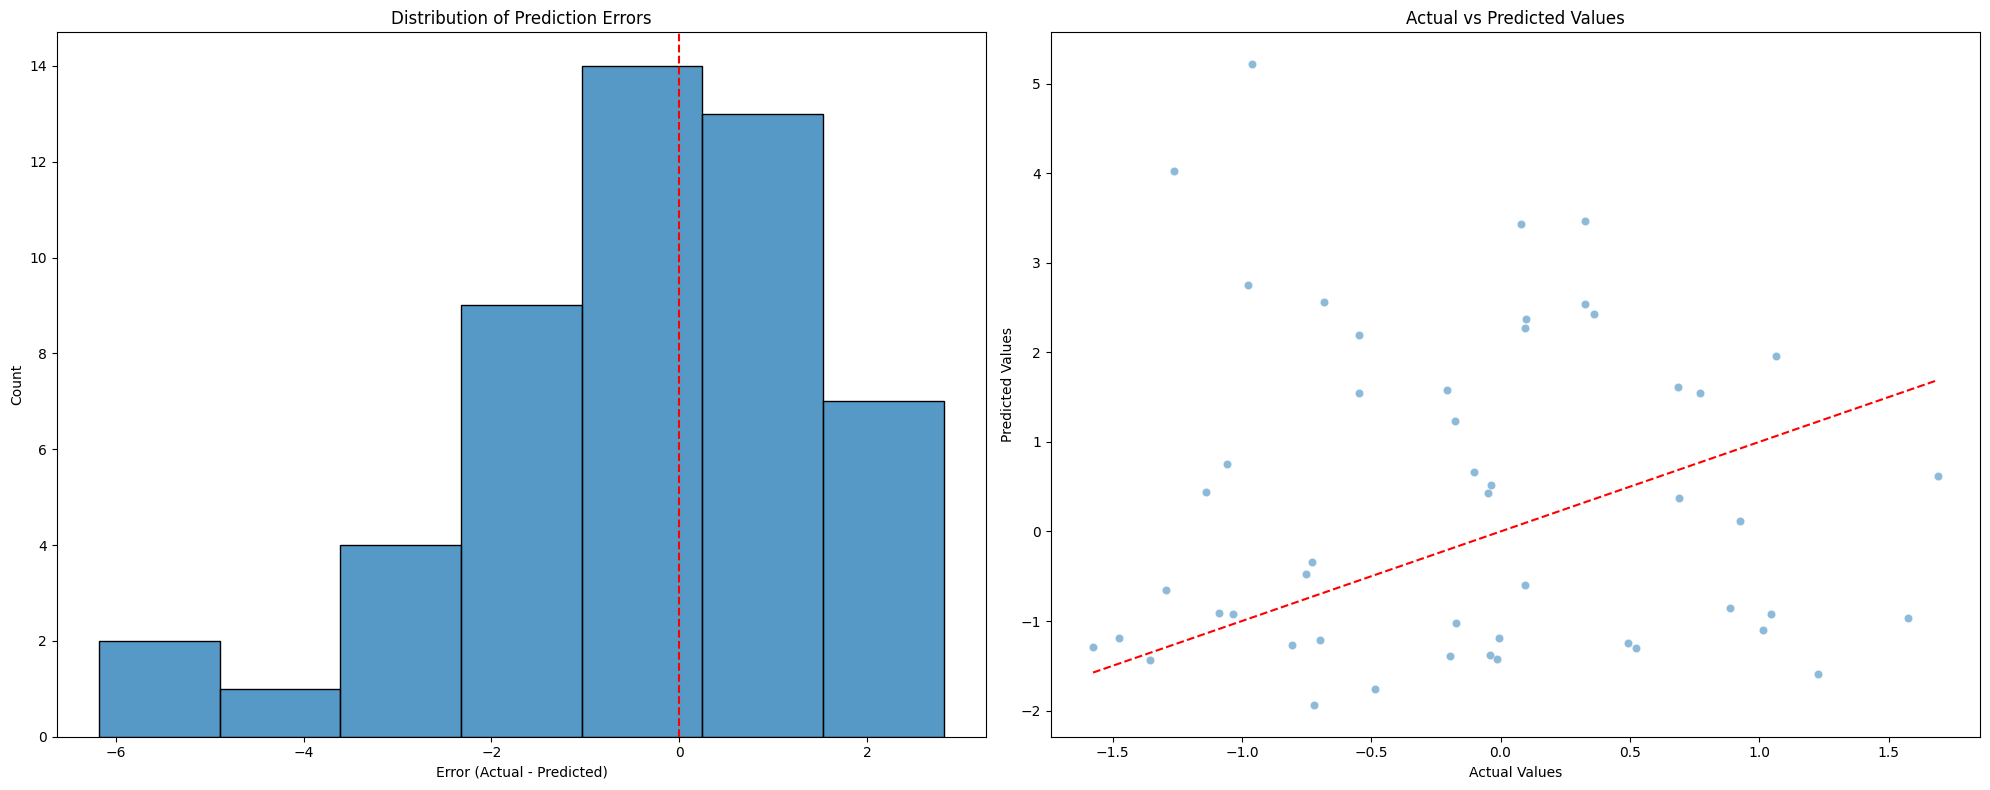


Model Performance Metrics:
MAE: 1.5756
RMSE: 2.0159
Log Likelihood: -221.9021

Baseline Error Metrics (Using PID means):
MAE: 0.7040
RMSE: 0.8487


In [307]:
# Subset PIDs with most extreme correlations

predictor = 'passive_hk_activity_activeEnergyBurned'
target = 't_current'

train_subset = train_data[train_data['PID'].isin(most_positive_t)]
test_subset = test_data[test_data['PID'].isin(most_positive_t)]

fit_and_predict_mlm(train_subset, test_subset, predictor, target='t_current', random_intercepts=False)

# Calculate baseline error
# Calculate mean target value per PID in training data
pid_means = train_subset.groupby('PID')[target].mean()

# Make predictions using PID means
predictions = []
actuals = []

for pid in test_subset['PID'].unique():
    # Get test data for this PID
    pid_test_data = test_subset[test_subset['PID'] == pid]
    
    # Use training mean for this PID as prediction
    if pid in pid_means:
        pred_value = pid_means[pid]
        predictions.extend([pred_value] * len(pid_test_data))
        actuals.extend(pid_test_data[target].values)

predictions = np.array(predictions)
actuals = np.array(actuals)

# Calculate errors
errors = actuals - predictions
mae = np.nanmean(np.abs(errors))
rmse = np.sqrt(np.nanmean(errors**2))

print("\nBaseline Error Metrics (Using PID means):")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


In [176]:
predictor = 'passive_hk_activity_activeEnergyBurned'
target = 't_current'

# Prepare training data
model_data = train_data[train_data['PID'].isin(most_negative_t)]
model_data = model_data[[predictor, target, 'PID']].dropna()

# Prepare test data
test_subset = test_data[test_data['PID'].isin(most_negative_t)]
test_subset = test_subset[[predictor, target, 'PID']].dropna()

# Fit model with random slopes and intercepts
md = smf.mixedlm(f"{target} ~ 0 + {predictor}", 
                 model_data,
                 groups=model_data["PID"],
                 re_formula=f"0 + {predictor}")

fit = md.fit(method='nm',
            maxiter=1000,
            start_params=None,
            full_output=True)

# Make predictions on test data including random effects
predictions = []
for pid in test_subset['PID'].unique():
    pid_data = test_subset[test_subset['PID'] == pid]
    # Get predictions for this subject
    pred = fit.predict(pid_data)
    predictions.extend(pred)

predictions = np.array(predictions)

# Calculate errors
errors = test_subset[target] - predictions
mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))

# Print model summary and error metrics
print(fit.summary())
print(f"\nTest Set Error Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

                        Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           t_current
No. Observations:           393               Method:                       REML     
No. Groups:                 10                Scale:                        0.8385   
Min. group size:            10                Log-Likelihood:               -524.5990
Max. group size:            61                Converged:                    Yes      
Mean group size:            39.3                                                     
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
passive_hk_activity_activeEnergyBurned     -0.454    0.051 -8.833 0.000 -0.554 -0.353
passive_hk_activity_activeEnergyBurned Var  0.000    0.011                    

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Top 1 Predictor

In [83]:
# Function to fit and predict single predictor MLM

def fit_and_predict_mlm(train_data, test_data, predictor, target='t_current', random_intercepts=False):
    """
    Fits a mixed linear model on training data and makes predictions on test data.
    Model has no intercept and random slopes.
    
    Parameters:
    -----------
    train_data : pandas.DataFrame
        Training dataset containing predictor, target, and grouping variable ('PID')
    test_data : pandas.DataFrame
        Test dataset containing same columns as train_data
    predictor : str
        Name of the predictor variable
    target : str
        Name of the target variable (default: 't_current')
    random_intercepts : bool
        Whether to include random intercepts in the model (default: False)
    
    Returns:
    --------
    tuple: (predictions, mae, rmse, model)
        predictions: numpy.array of predictions for test data
        mae: Mean Absolute Error on test data
        rmse: Root Mean Square Error on test data 
        model: Fitted model object
    """
    # Prepare training data
    train_data_clean = train_data[[predictor, target, 'PID']].dropna()
    
    # Fit model based on random_intercepts parameter
    if random_intercepts:
        md = smf.mixedlm(f"{target} ~ 1 + {predictor}",
                        train_data_clean,
                        groups=train_data_clean["PID"],
                        re_formula=f"1 + {predictor}")
    else:
        md = smf.mixedlm(f"{target} ~ 1 + {predictor}",
                         train_data_clean,
                         groups=train_data_clean["PID"],
                         re_formula=f"0 + {predictor}")
    
    try:
        model = md.fit(method='lbfgs', maxiter=1000)
    except:
        # Try alternate optimizer if lbfgs fails
        model = md.fit(method='nm', maxiter=1000)
    
    # Prepare test data
    test_data_clean = test_data[[predictor, target, 'PID']].dropna()
    
    # Predictions start at zero
    predictions = np.zeros(len(test_data_clean))
    
    # Get random effects for all subjects
    random_effects = model.random_effects
    
    # For each subject in test data
    for pid in test_data_clean['PID'].unique():
        mask = test_data_clean['PID'] == pid
        subject_data = test_data_clean[mask]
        
        if pid in random_effects:
            # Get subject's random effects if available
            re_slope = random_effects[pid].get(predictor, 0)
            # For random intercepts, we need to get the 'Group' effect
            re_intercept = random_effects[pid].get('Group', 0) if random_intercepts else 0
        else:
            # Default to 0 if subject not in random effects
            re_slope = 0
            re_intercept = 0
        
        # Calculate prediction using fixed effect + random effects
        if random_intercepts:
            # Include the fixed intercept when using random intercepts
            fixed_intercept = model.params.get('Intercept', 0)
            predictions[mask] = (fixed_intercept + re_intercept) + (model.params[predictor] + re_slope) * subject_data[predictor]
        else:
            predictions[mask] = (model.params[predictor] + re_slope) * subject_data[predictor]
    
    
    # Calculate metrics
    test_actual = test_data_clean[target]
    mae = np.mean(np.abs(test_actual - predictions))
    rmse = np.sqrt(np.mean((test_actual - predictions)**2))
    
    # Create visualization plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    
    # Plot 1: Error distribution
    errors = test_actual - predictions
    sns.histplot(data=errors, ax=ax1)
    ax1.axvline(x=0, color='red', linestyle='--')
    ax1.set_title('Distribution of Prediction Errors')
    ax1.set_xlabel('Error (Actual - Predicted)')
    ax1.set_ylabel('Count')
    
    # Plot 2: Actual vs Predicted
    sns.scatterplot(x=test_actual, y=predictions, ax=ax2, alpha=0.5)
    ax2.plot([test_actual.min(), test_actual.max()],
             [test_actual.min(), test_actual.max()],
             'r--')
    ax2.set_title('Actual vs Predicted Values')
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print(f"\nModel Performance Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Log Likelihood: {model.llf:.4f}")
    
    # return predictions, mae, rmse, model

In [ ]:
predictor = mlm_gap_results_df.iloc[0]['feature']

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


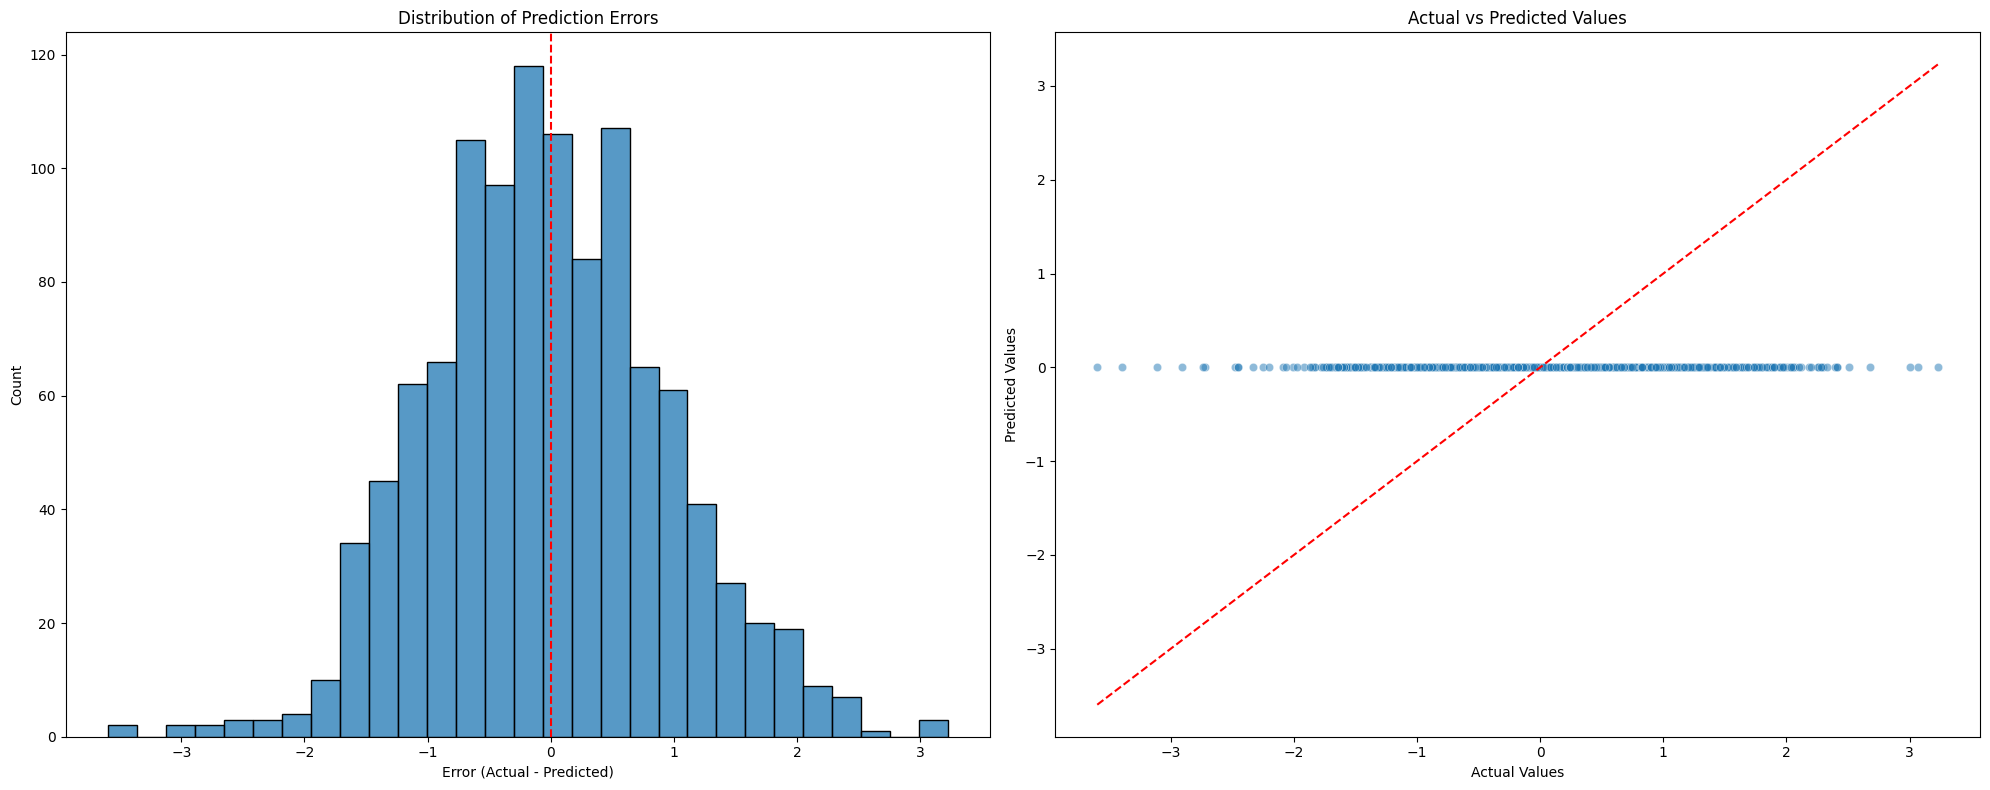


Model Performance Metrics:
MAE: 0.7559
RMSE: 0.9532
Log Likelihood: -6594.7883


In [84]:
# Normalized target, no intercept
fit_and_predict_mlm(train_data, test_data, predictor, target='t_current', random_intercepts=False)

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 319.004729
  warnings.warn(msg, ConvergenceWarning)
/U

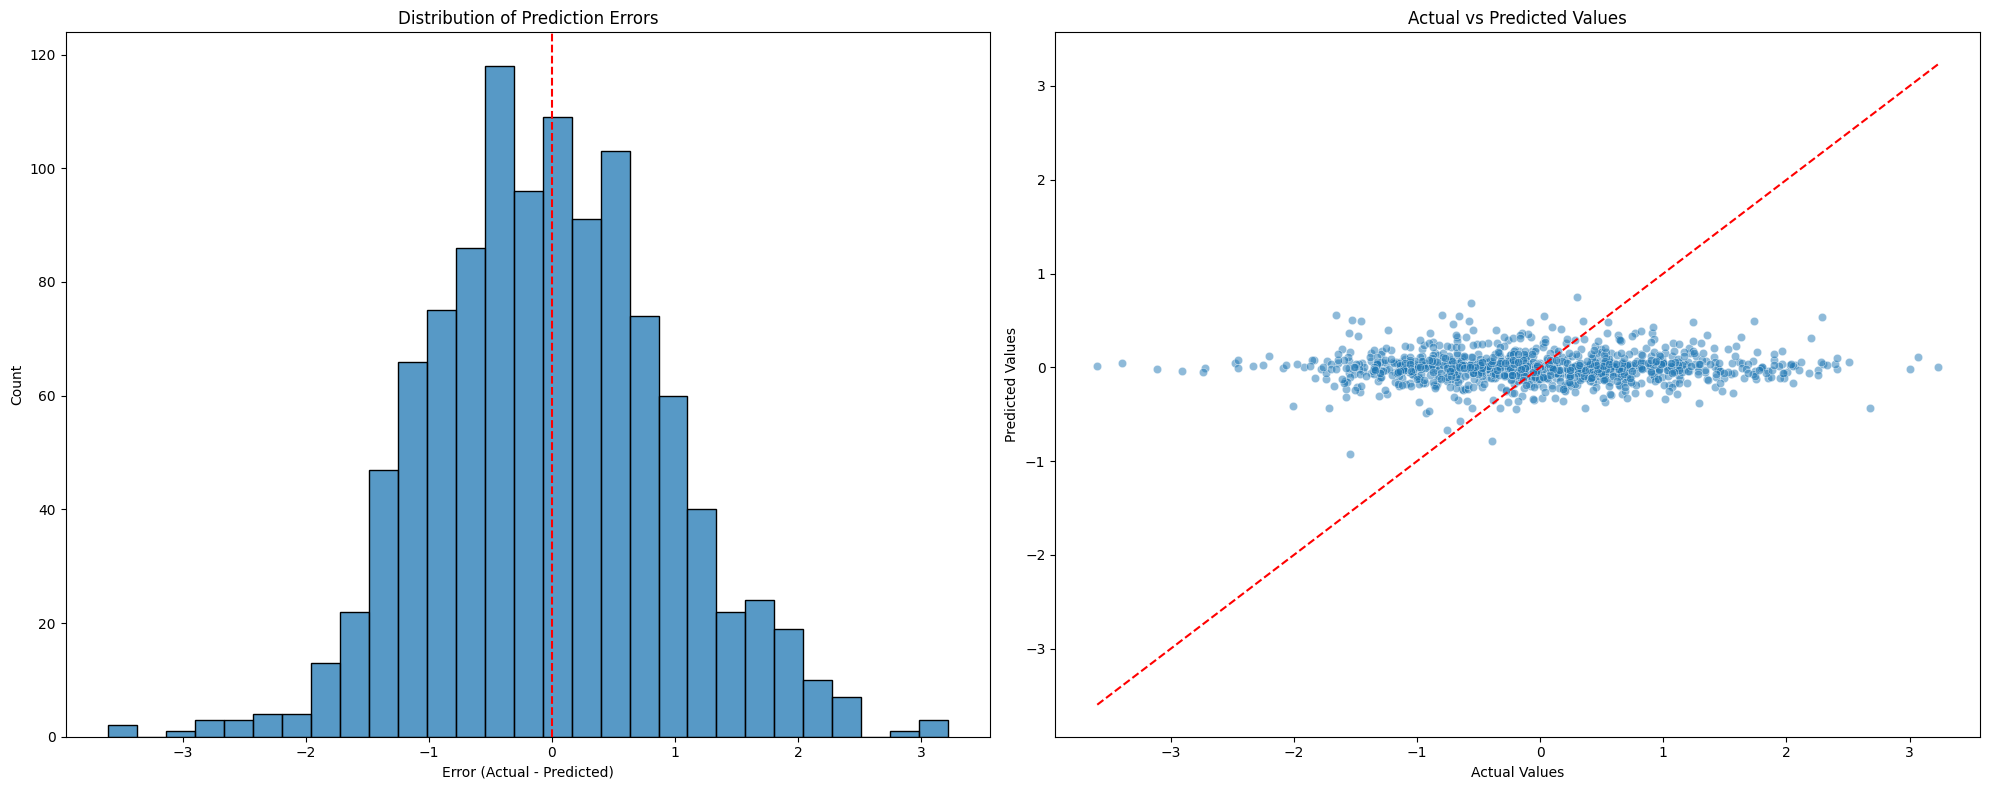


Model Performance Metrics:
MAE: 0.7650
RMSE: 0.9610
Log Likelihood: -6656.7791


In [85]:
# Normalized target, no intercept
fit_and_predict_mlm(train_data, test_data, predictor, target='t_current', random_intercepts=True)

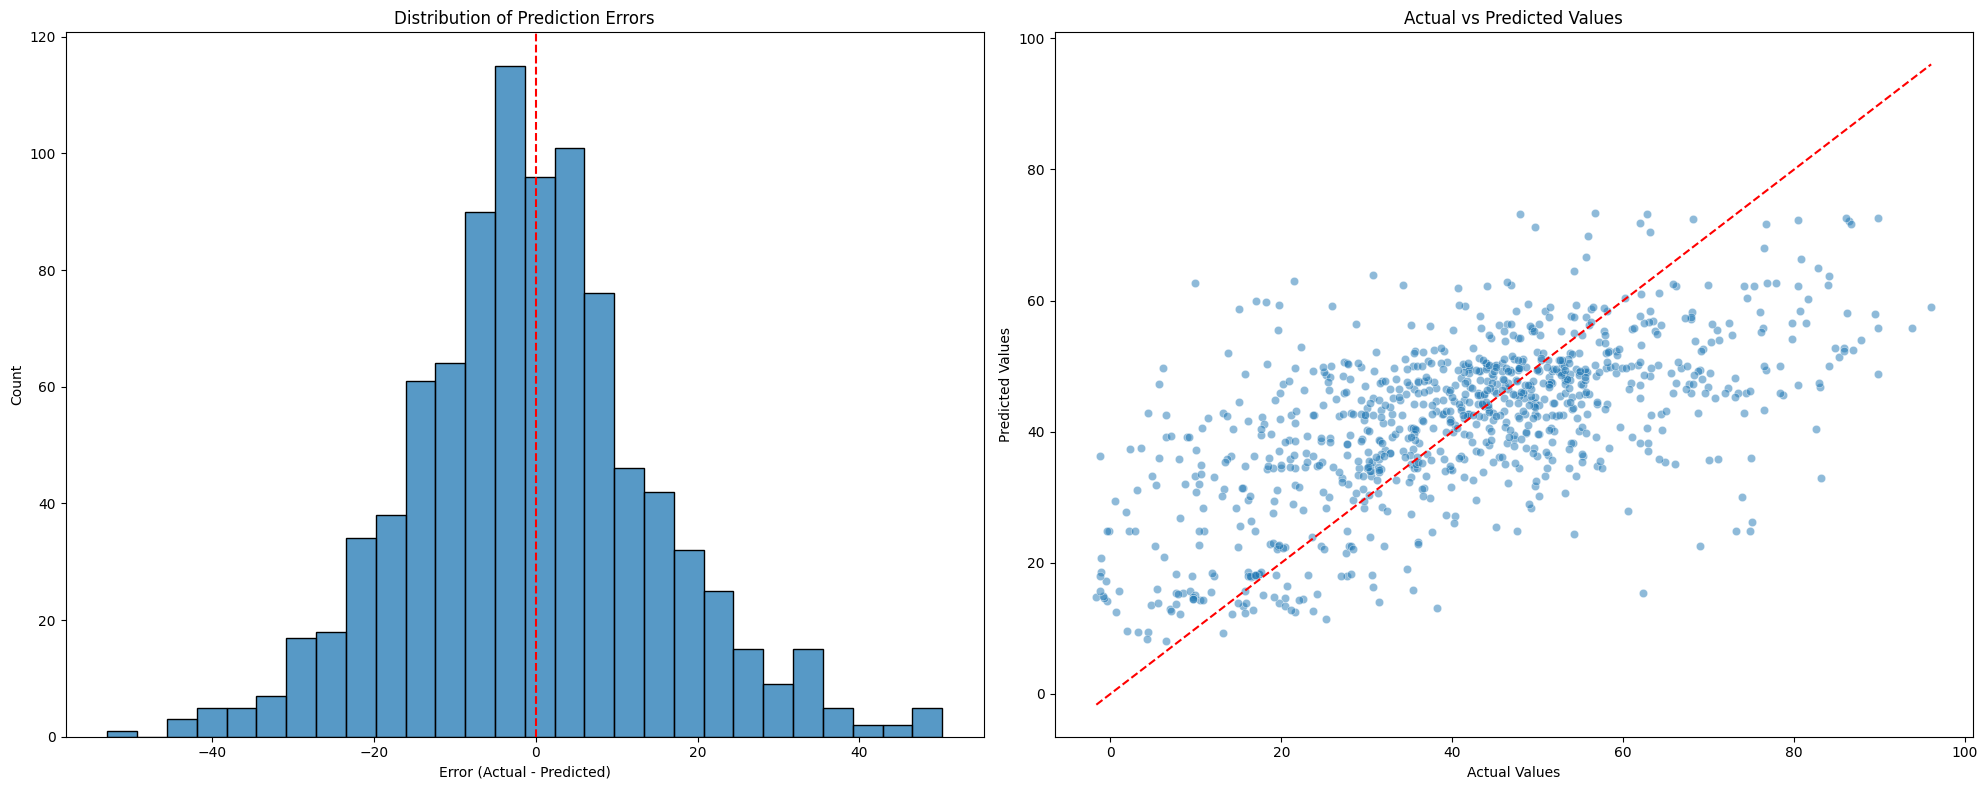


Model Performance Metrics:
MAE: 11.7269
RMSE: 15.3189
Log Likelihood: -17710.4592


In [101]:
predictor = 'passive_hk_activity_activeEnergyBurned'
# Non-normalized target
fit_and_predict_mlm(train_data, test_data, predictor, target='t_current_nn', random_intercepts=True)

## Top 2 Predictors

## Top 3 Predictors

Check when BIC starts dropping